# My TTN library
In this notebook I try to develop my personal library to handle TTNs, their definition, properties, automatic contraction and training.

In [39]:
import torch
import numpy as np
from typing import Sequence, List, Tuple
import graphviz
from matplotlib import colormaps, colors
import colorsys

In [9]:
cat = np.linspace(0.1, 1, 6)
colormaps.get_cmap('viridis')(0.3)

(0.206756, 0.371758, 0.553117, 1.0)

## Automatic contractions
Try to develop methods to do automatic contractions, also based on the network structure (separability of states)
### Network description

In [70]:
from __future__ import annotations
from collections import UserString

class TIndex:
    def __init__(self, name, inds: Sequence[str]):
        self.__name = name
        self.__indices = np.array(inds, dtype=np.str_) # problems with string lenghts
        self.__dims = len(inds)
    
    def __getitem__(self, key: int) -> str:
        return self.__indices[key]
    
    def __setitem__(self, key: int, value: str):
        old_len = self.__indices.dtype.itemsize / 4
        new_len = max(old_len, len(value))
        self.__indices = self.__indices.astype(f"<U{new_len:.0f}")
        self.__indices[key] = value
    
    @property
    def name(self):
        return self.__name 

    @property
    def indices(self):
        return self.__indices
    
    @property
    def dims(self):
        return self.__dims
    
    ''' I do not want them to be changed by design   
    @indices.setter
    def indices(self, value: Sequence[str]):
        self.__indices = value
    '''
    
    def __eq__(self, __value: TIndex | str) -> bool:
        if isinstance(__value, str):
            return self.__name == __value
        return self.__name == __value.name and np.all(self.__indices == __value.indices)
    
    def __hash__(self):
        return hash(self.__name)
    
    def __str__(self) -> str:
        return self.__name
    
    def __repr__(self) -> str:
        return 'TIndex: ' + self.__name
    
    def _repr_markdown_(self):
        return f'**{self.__repr__()}**'
    
    def _repr_html_(self):
        markdown_str = f'<details><summary><b style="color:#0088d9; font-size:100%; font-family: verdana, sans-serif">{self.__repr__()} </b></summary>'
        for index in self.__indices:
            markdown_str += f'&emsp;&ensp; <b style="color:#be00d9">{index}</b><br>'
        return markdown_str + '</details>'
    
class TTNIndex(TIndex):
    def __init__(self, layer: int, layer_index: int):

        self.__layer = layer
        self.__layer_index = layer_index
        super(TTNIndex, self).__init__(f"{layer}.{layer_index}",
                                       [f"{layer+1}.{2*layer_index}", f"{layer+1}.{2*layer_index+1}", f"{layer}.{layer_index}"], 
                                       )
    
    def __repr__(self) -> str:
        return f"TTNIndex: {self.__layer}.{self.__layer_index}"


In [71]:
TTNIndex(5,1)

TTNIndex: 5.1

In [72]:
def adjust_lightness(color, amount=0.5):
    try:
        c = colors.cnames[color]
    except:
        c = color
    rgb = len(c) == 3
    c_hls = colorsys.rgb_to_hls(*colors.to_rgb(c))
    return colorsys.hls_to_rgb(c_hls[0], max(0, min(1, amount * c_hls[1])), c_hls[2]) + ((c[3],) if not rgb else ())

In [73]:
class TTN:
    def __init__(
        self,
        n_features,
        n_phys=2,
        n_labels=2,
        label_tag="label",
        bond_dim=4,
        dtype=torch.cdouble,
        device="cpu",
    ):
        if (n_features % 2) != 0:
            raise ValueError(f"n_features must be  power of 2, got: {n_features}")

        self.n_features = n_features
        self.n_phys     = n_phys
        self.n_labels   = n_labels
        self.label_tag  = label_tag
        self.bond_dim   = bond_dim
        self.device     = device

        self.__dtype    = dtype
        self.__n_layers = int(np.log2(n_features))
        self.__tensors  = []
        self.__indices  = [TTNIndex(l, i) for l in range(self.__n_layers) for i in range(2**l)]
        # label top edge as label
        self.__indices[0][2] = label_tag
        # label bottom edges as data
        for ttnindex in self.__indices[-2**(self.__n_layers-1):]:
            ttnindex[0] = f'data.{ttnindex[0].split(".")[1]}'
            ttnindex[1] = f'data.{ttnindex[1].split(".")[1]}'
        # convert to numpy array for easier indexing
        self.__indices = np.asarray(self.__indices)

        self.__initialized = False

        ## INITIALIZE TENSORS ##
        self.__id = np.zeros([self.bond_dim] * 3, dtype=np.float64)
        for i in range(self.__id.shape[0]):
            self.__id[i, i, i] = 1.0

        # add first tensor with special index
        if not (self.__n_layers - 1):
            self.__tensors.append(
                torch.rand(
                    size=(self.n_phys, self.n_phys, self.n_labels),
                    dtype=self.__dtype,
                    device=self.device
                )
            )
        else:
            dim = min(self.n_phys ** (self.__n_layers), self.bond_dim)
            self.__tensors.append(
                torch.rand(
                    size=(dim, dim, self.n_labels),
                    dtype=self.__dtype,
                    device=self.device
                )
            )

        for l in range(1, self.__n_layers - 1):  # constructing the ttn starting from the top
            dim_pre = min(self.n_phys ** (self.__n_layers - l), self.bond_dim)
            dim_post = min(self.n_phys ** (self.__n_layers - l + 1), self.bond_dim)
            self.__tensors.extend(
                [
                    torch.rand(
                        size=[dim_pre] * 2 + [dim_post],
                        dtype=self.__dtype,
                        device=self.device
                    )
                    if np.random.rand() < 0.5
                    else torch.as_tensor(
                        data=self.__id[:dim_pre, :dim_pre, :dim_post],
                        dtype=self.__dtype,
                        device=self.device
                    )
                    for i in range(2**l)
                ]
            )

        dim = min(self.n_phys**2, self.bond_dim)
        self.__tensors.extend(
            [
                torch.rand(
                    size=[self.n_phys] * 2 + [dim],
                    dtype=self.__dtype,
                    device=self.device
                )
                for i in range(2 ** (self.__n_layers - 1))
            ]
        )
        ########################
        self.__tensor_map = dict(zip(self.__indices, self.__tensors))
    
    def __getitem__(self, key: Sequence[TTNIndex | str] | str | int | slice) -> dict[TTNIndex, torch.Tensor]:

        if isinstance(key, int):
            return {self.__indices[key]: self.__tensor_map[self.__indices[key]]}
        elif isinstance(key, str):
            return {self.__indices[self.__indices==key]: self.__tensor_map[key]}
        elif isinstance(key, Sequence):
            return {k if isinstance(k, TTNIndex) else self.__indices[self.__indices==k]: self.__tensor_map[k] for k in key}
        elif isinstance(key, slice):
            return {k: self.__tensor_map[k] for k in self.__indices[key]}
        else:
            raise TypeError(f"Invalid argument type: {type(key)}")
        
    @property
    def indices(self):
        return self.__indices
    
    @property
    def tensors(self):
        return self.__tensors
        
    def __repr__(self) -> str:
        return f"TTN"
    
    def _repr_html_(self):
        markdown_str = f'<details><summary><b style="color:#d95100; font-size:100%; font-family: verdana, sans-serif">{self.__repr__()} </b></summary>'
        for tindex in self.__indices:
            markdown_str += f'{tindex._repr_html_()}'
        return markdown_str + '</details>'
    
    def draw(self, name='TTN', cmap='viridis', fontsize=11):
        cmap = colormaps.get_cmap(cmap)
        categories = np.linspace(0.2, 1, self.__n_layers)
        dot = graphviz.Digraph(name, comment='TTN: ' + name, format='svg', engine='dot', renderer='cairo', graph_attr={'bgcolour': 'transparent', 'rankdir': 'LR', 'splines':'false', 'size':'16,14', 'ratio':'compress', 'fontname':'Arial'})
        dot.attr('node', shape='circle', width='0.35', fixedsize='true', fontsize=str(fontsize))
        dot.attr('edge', color='#bfbfbf', fontsize=str(fontsize-2))
        dot.edge('0.0', 'hide', label=self.label_tag)
        dot.node('hide', '', shape='plaintext')
        for tindex in self.__indices:
            c_rgba = list(cmap(categories[int(tindex.name.split('.')[0])]))

            dot.node(tindex.name, tindex.name, fillcolor=colors.rgb2hex(c_rgba), style='filled', color=colors.rgb2hex(adjust_lightness(c_rgba, amount=0.8)), penwidth='4')
            
            dot.edge(tindex[0], tindex.name, label=tindex[0], weight=str((int(tindex.name.split('.')[0])+1)**2))
            dot.edge(tindex[1], tindex.name, label=tindex[1], weight=str((int(tindex.name.split('.')[0])+1)**2))
        
        for i in range(2**self.__n_layers):
            dot.node(f'data.{i}', '', shape='plaintext', width='0.1', height='0.1')
        return dot

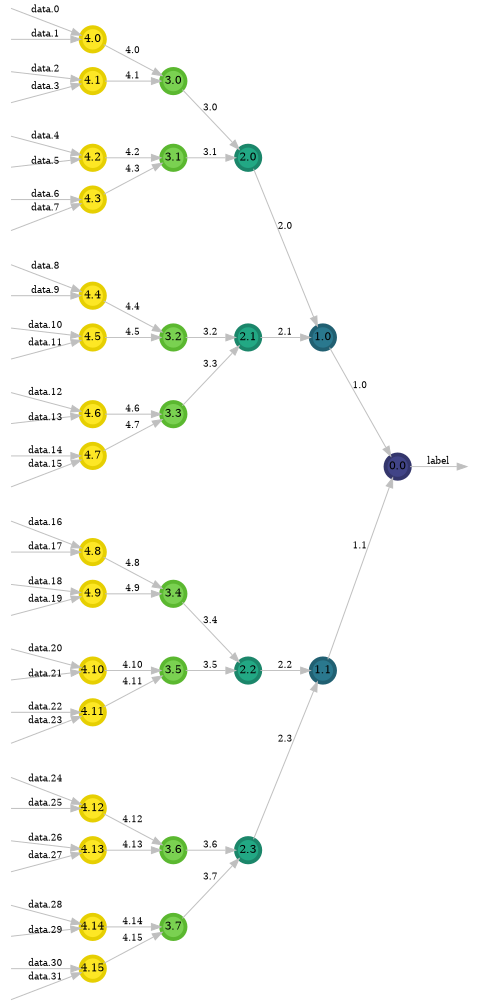

In [74]:
ttn = TTN(32)
ttn.draw()

### Basic operations

In [ ]:
def contract_2(A: torch.Tensor, B: torch.Tensor, tindices: Sequence[TTNIndex], keep: Sequence[TIndex | str] | None=None):
    """
    Contract two tensors along the matching TIndices in indices, except for the indices in keep.
    """
    if len(tindices) != 2:
        raise ValueError(f"Expected 2 indices, got {len(tindices)}")

    if keep is None:
        keep = []
    elif isinstance(keep, TIndex) or isinstance(keep, str):
        keep = [keep]

    # find indices to contract
    contract_inds = [i for i in tindices[0].indices if i in tindices[1].indices and i not in keep]

    # find output indices
    output_inds = [i for i in tindices[0].indices if i not in contract_inds] + [i for i in tindices[1].indices if i not in contract_inds]


    

## Torch Model

In [ ]:
def ttn_to_torchscript(ttn: TTN, name: str) -> torch.jit.ScriptModule:
    """Convert a TTN to a torchscript module.
    
    Args:
        ttn (TTN): The TTN to convert.
        name (str): The name of the torchscript module.
    
    Returns:
        torch.jit.ScriptModule: The torchscript module.
    """
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """The forward pass of the torchscript module.
        
        Args:
            x (torch.Tensor): The input tensor.
        
        Returns:
            torch.Tensor: The output tensor.
        """
        x = torch.einsum('ij,jkl->ikl', x, self.tensors[0])
        for i in range(1, len(self.tensors)):
            x = torch.einsum('ij,jkl->ikl', x, self.tensors[i])
        return x

    return torch.jit.script(
        torch.nn.ModuleDict(
            {
                'tensors': torch.nn.ParameterList(
                    [torch.nn.Parameter(t, requires_grad=True) for t in ttn.tensors]
                ),
                'forward': torch.jit.script(forward)
            }
        )
    )